PyTorch提供优雅设计的模块和类`torch.nn`，`torch.optim`，`Dataset`和`DataLoader`，以帮助您创建和训练神经网络。 为了充分利用他们的力量并根据您的问题定制它们，您需要真正了解他们究竟有什么作用。 为了突出这种理解，我们将首先在MNIST数据集上训练基本神经网络，而不使用这些模型的任何特征; 我们最初只会使用最基本的PyTorch张量功能。 然后，我们将逐步添加来自torch.nn，torch.optim，Dataset或DataLoader的一个功能，准确显示每个部分发挥什么作用，以及它如何使代码更简洁或更灵活。

### MNIST Data Setup

我们将使用经典的MNIST数据集，其中包括手绘数字的黑白图像（0到9之间）。

我们将使用`pathlib`来处理路径（Python3标准库的一部分），并将使用`requests`下载数据集。 我们只会在使用模块时导入模块，因此你可以准确地看到每个模块的使用情况。

In [3]:
from pathlib import Path
import requests

DATA_PATH = Path("./data")
PATH = DATA_PATH/"mnist"
PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

该数据集采用numpy数组格式，并使用pickle存储，pickle是一种特定于python的格式，用于序列化数据。

In [4]:
import pickle
import gzip

with gzip.open(PATH / FILENAME, "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

每个图像为28 x 28，并存储为长度为784（= 28x28）的扁平行。 我们来看看一个; 我们需要先将其重塑为2d。

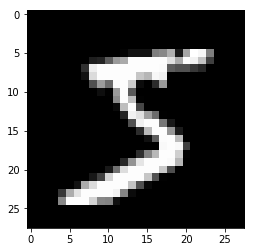

(50000, 784)


In [6]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
pyplot.show()
print(x_train.shape)

PyTorch使用torch.tensor而不是numpy数组，因此我们需要转换数据。

In [7]:
import torch

x_train,y_train,x_valid,y_valid = map(torch.tensor,(x_train,y_train,x_valid,y_valid))

n,c = x_train.shape
x_train, x_train.shape,y_train.min(),y_train.max()
print(x_train,y_train)
print(x_train.shape)
print(y_train.min(),y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [8]:
n

50000

In [9]:
c

784

### Neural net from scratch(no torch.nn)

PyTorch提供了创建随机或零填充张量的方法，我们将使用这些方法为简单的线性模型创建权重和偏差。 这些只是普通的张量，只有一处非常特殊：我们告诉PyTorch，他们需要一个梯度。 这会导致PyTorch记录在张量上完成的所有操作，以便它可以在反向传播过程中自动计算梯度！

对于权重，我们在初始化之后设置requires_grad，因为我们不希望梯度中包含该步骤。 （请注意，PyTorch中的trailling _表示操作是就地执行的。）

**Note:** 我们在这里用Xavier初始化初始化权重（乘以1/sqrt(n)）

In [10]:
import math

weights = torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10,requires_grad=True)


由于PyTorch的自动计算梯度，我们可以使用任何标准的Python函数（或可调用对象）作为模型的能力！ 因此，让我们编写一个简单的矩阵乘法和广播加法来创建一个简单的线性模型。 我们还需要一个激活函数，所以我们将编写log_softmax并使用它。 记住：虽然PyTorch提供了许多预先编写的损失函数，激活函数等，但您可以使用普通的python轻松编写自己的函数。 PyTorch甚至可以自动为您的函数创建快速GPU或矢量化CPU的代码。

In [11]:
def log_softmax(x):
    return x-x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias) # 觉得此处还是使用矩阵乘法更合适，如xb.mm(weights)


在上面，@代表点积运算。 我们将在一批数据上调用我们的函数（在这种情况下，64个图像）。 这是一个前向传播。 请注意，我们的预测在这个阶段不会比随机更好，因为我们从随机权重开始。

In [12]:
bs = 64 # batch size

xb = x_train[0:bs] # a mini-batch from x
preds = model(xb)
preds[0],preds.shape
print(preds[0],preds.shape)

tensor([-2.1461, -2.4161, -2.0080, -2.2750, -2.6348, -2.5785, -2.0887, -2.4160,
        -2.5338, -2.1486], grad_fn=<SelectBackward>) torch.Size([64, 10])


如您所见，preds张量不仅包含张量值，还包含梯度函数。 我们稍后会用它来做backprop。

让我们利用Python手动实现负对数似然，用作损失函数。

In [52]:
def nll(input,target):
    return -input[range(target.shape[0]),target].mean()

loss_func = nll

让我们用我们的随机模型检查我们的损失，这样我们就可以看到我们是否在后面的backprop传递后有所进步。

In [53]:
yb = y_train[0:bs]

In [54]:
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1,
        1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5,
        9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [55]:
print(loss_func(preds,yb))

tensor(2.3462, grad_fn=<NegBackward>)


我们还实现了一个计算模型精度的函数。 对于每个预测，如果具有最大值的索引与目标值匹配，则预测是正确的。

In [68]:
def accuracy(out,yb):
    preds = torch.argmax(out,dim=1)
    return (preds==yb).float().mean()

让我们检查一下随机模型的准确性，这样我们就可以看出随着损失的改善我们的准确度是否会提高。

In [69]:
print(accuracy(preds, yb))

tensor(0.1094)


我们现在可以运行一个训练循环。 对于每次迭代，我们将：
- 选择一小批数据（大小为bs）
- 使用模型进行预测
- 计算损失
- loss.backward（）更新模型的梯度，在这里，即权重和偏差。

我们现在使用这些梯度来更新权重和偏差。 我们在`torch.no_grad()`上下文管理器中执行此操作，因为我们不希望记录这些操作以用于下一次计算梯度。 

然后我们将梯度设置为零，以便我们为下一个循环做好准备。 否则，我们的梯度将记录已发生的所有操作的运行记录（即`loss.backward()`将梯度添加到任何已存储的地方，而不是替换它们）。

你可以使用标准的python调试器来逐步执行PyTorch代码，允许您在每一步检查各种变量值。 取消注释下面的`set_trace()`以试用它。


In [70]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

就是这样：我们创建并训练了一个最小的神经网络（在这里，是一个逻辑回归，因为我们没有隐藏的层）完全从头开始！

让我们检查损失和准确率，并将它们与我们之前得到的结果进行比较。 我们预计损失会减少，准确性会增加，我们看到结果确实有。

In [71]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0831, grad_fn=<NegBackward>) tensor(1.)


### Using `torc.nn.functional`

我们现在将重构我们的代码，它和上面功能一样，只是我们会开始利用PyTorch的nn类来使它更简洁和灵活。在这里的每一步，我们应该使我们的代码更短，更易理解或更灵活。

第一个也是最简单的步骤是通过将手写的激活和损失函数替换为来自`torch.nn.functional`（通常按惯例导入到命名空间`F`）的函数来缩短代码。该模块包含`torch.nn`库中的所有函数（而库的其他部分包含类）。除了各种各样的损失和激活功能外，你还可以在这里找到一些用于创建神经网络的便捷功能，例如池化函数。（还有用于进行卷积，线性层等的函数，但正如我们将看到的，通常可以使用库的其他部分更好地处理这些函数。）

如果你使用负对数似然丢失和log softmax激活，那么Pytorch提供了一个结合了两者的单个函数`F.cross_entropy`。所以我们甚至可以从模型中删除激活函数。

In [73]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights +bias

现在我们不再在model函数中调用log_softmax函数，让我们来看一下我们的损失、准确率情况如何：

In [74]:
print(loss_func(model(xb),yb),accuracy(model(xb),yb))

tensor(0.0831, grad_fn=<NllLossBackward>) tensor(1.)


### Refactor using `nn.Module`

接下来，我们将使用`nn.Module`和`nn.Parameter`，以获得更清晰，更简洁的训练循环。 我们继承`nn.Module`（它本身是一个类，能够跟踪状态）。 在这里，我们想要创建一个包含前向步长的权重、偏置和方法的类。 `nn.Module`有许多我们将要使用的属性和方法（例如`.parameters()`和`.zero_grad()`）。

`nn.Module`（大写M）是一个PyTorch特定的概念，是一个我们将会经常使用的类。 `nn.Module`不要与（小写m）模块module的Python概念混淆，后者是可以导入的Python代码文件。

In [75]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10)/math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self,xb):
        return xb @ self.weights + self.bias
    

由于我们现在使用的是对象而不是仅使用函数，因此我们首先必须实例化我们的模型：

In [76]:
model = Mnist_Logistic()

现在我们可以像以前一样计算损失。 请注意，`nn.Module`对象被用作函数（即它们是可调用的），但在幕后Pytorch会自动调用我们的forward方法。

In [77]:
print(loss_func(model(xb),yb))

tensor(2.3413, grad_fn=<NllLossBackward>)


在上面，对于我们的训练循环，我们必须按名称更新每个参数的值，并分别手动将每个参数的梯度归零，如下所示：
```python
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

```

现在我们可以利用`model.parameters()`和`model.zero_grad()`（它们都由PyTorch为`nn.Module`定义的）使这些步骤更简洁，更不容易忘记我们的一些参数，特别是如果我们有一个更复杂的模型时：
```python
with torch.no_grad():
    for p in model.parameters(): 
        p -= p.grad * lr
    model.zero_grad()

```

我们将我们的小的训练循环包装在fit函数中，以便我们稍后可以再次运行它。

In [84]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

检查一下损失值是否下降了：

In [85]:
print(loss_func(model(xb), yb))

tensor(0.0824, grad_fn=<NllLossBackward>)


### Refactor using `nn.Linear`

我们继续重构我们的代码。 我们现在不用手动定义和初始化`self.weights`和`self.bias`，计算`xb @ self.weights + self.bias`，而是使用Pytorch类nn.Linear作为线性层，它为我们做了所有这些。 Pytorch有许多类型的预定义层，可以大大简化我们的代码，并且通常也使它更快。

In [86]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

我们像上面一样初始化我们的模型并计算损失值：

In [87]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3445, grad_fn=<NllLossBackward>)


我们再次使用上面定义好的fit方法：

In [88]:
fit()
print(loss_func(model(xb),yb))

tensor(0.0813, grad_fn=<NllLossBackward>)


### Refactor using optim

Pytorch还有一个包含各种优化算法的软件包，`torch.optim`。 我们可以使用优化器中的`step`方法来执行前进步骤，而不是手动更新每个参数。

我们之前手动编写的以下优化步骤可以被取代了：
```python3
with torch.no_grad():
    for p in model.parameters(): p -= p.grad * lr
    model.zero_grad()

```

我们可以替换为：
```python
opt.step()
opt.zero_grad()
```

（`optim.zero_grad()`将梯度重置为0，我们需要在计算下一个小批量的梯度之前调用它。）

In [89]:
from torch import optim

我们将定义一个函数来创建我们的模型和优化器，以便将来可以重用它。

In [90]:
def get_model():
    model = Mnist_Logistic()
    return model,optim.SGD(model.parameters(),lr=lr)

model, opt = get_model()
print(loss_func(model(xb),yb))

for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step() # 根据梯度更新参数（比如权重和偏置）
        opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(2.3131, grad_fn=<NllLossBackward>)
tensor(0.0809, grad_fn=<NllLossBackward>)


### Refactor using Dataset

PyTorch有一个抽象的Dataset类。 数据集可以是任何具有`__len__`函数（由Python的标准len函数调用）和`__getitem__`函数作为索引的方式。

PyTorch的TensorDataset是一个包含张量的数据集。 通过定义索引的长度和方式，这也为我们提供了一种沿张量的第一维迭代，索引和切片的方法。 这样可以更方便地在我们训练的同一行中访问独立变量和因变量。

In [91]:
from torch.utils.data import TensorDataset

In [92]:
train_ds = TensorDataset(x_train,y_train)

In [93]:
train_ds

之前，我们通过以下代码实现在小的批次上迭代x和y:
```python
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]
```

现在，我们可以两步并做一步的使用下面的代码完成同样的功能：
```python
xb,yb = train_ds[i*bs:i*bs+bs]

```

In [94]:
model,opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward>)


### Refactor using `DataLoader`

PyTorch的DataLoader负责管理批次。 你可以给任何一个数据集创建`DataLoader`。 `DataLoader`使得批量迭代变得更容易。 `DataLoader`不是使用`train_ds [i * bs：i * bs + bs]`，而是自动为我们提供每一个小的批次。

In [95]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)

train_dl = DataLoader(train_ds, batch_size=bs)

之前，我们通过以下代码在批次上迭代(xb,yb)：
```python
for i in range((n-1)//bs + 1):
    xb,yb = train_ds[i*bs : i*bs+bs]
    pred = model(xb)
```

现在我们的循环更加的简单，因为(xb,yb)自动从数据载入器中载入，如下：
```python
for xb,yb in train_dl:
    pred = model(xb)
```

In [96]:
model,opt = get_model()

for epoch in range(epochs):
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred,yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb),yb))

tensor(0.0815, grad_fn=<NllLossBackward>)


感谢Pytorch的`nn.Module`，`nn.Parameter`，`Dataset`和`DataLoader`，我们的训练循环现在变得更小，更容易理解。 现在让我们尝试添加在实践中创建有效模型所需的基本功能。

### Add validation

在第1部分中，我们只是试图为我们的训练数据设置合理的训练循环。实际上，你总是应该有一个验证集，以确定您是否过拟合。

随机打乱训练数据对于防止批次之间具有相关性和过拟合非常重要。另一方面，无论我们是否对验证集进行随机打乱，验证集损失都是一样的。由于随机打乱也需要额外的时间，因此对验证集数据进行随机打乱是没有意义的。

我们将验证集的batch_size设置为训练集batch_size大小的两倍。 这是因为验证集不需要反向传播，因此占用的内存更少（不需要存储梯度）。 我们利用这一点来使用更大的批次大小来更快地计算损失。

In [97]:
train_ds = TensorDataset(x_train,y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid,y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

我们将在每个epoch结束时计算并打印验证集损失。

**注意**，我们总是在训练之前调用`model.train()`，在推理之前调用`model.eval()`，因为这些由诸如`nn.BatchNorm2d`和`nn.Dropout`这些层使用，以确保这些不同阶段的适当行为。

In [98]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2974)
1 tensor(0.3108)
